In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

In [2]:
with open('graph_objects/G_simple_directed.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [3]:
# Dataset; 'iggin' or 'iggielgn'
dataset = 'iggin'

# S-t-flow; 's-t-degree' or 's-t-type'
s_t_flow = 's-t-degree'

In [4]:
node_removals_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_node_removal_df.pkl')
# edge_removals_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_edge_removal_df.pkl')

# Network Impact Heatmap
Based on impact on evaluated metric by given removal

In [5]:
metric = 'capacity_robustness_max_flow'
# Add a column to the df that contains the difference between the max flow of the original graph and the max flow of the graph after the removal
node_removals_df[metric+'_diff'] = node_removals_df[metric].diff().abs()
# edge_removals_df[metric+'_diff'] = edge_removals_df[metric].diff().abs()

# Normalize the difference
node_removals_df[metric+'_diff_norm'] = node_removals_df[metric+'_diff']/node_removals_df[metric+'_diff'].max()
# edge_removals_df[metric+'_diff_norm'] = edge_removals_df[metric+'_diff']/edge_removals_df[metric+'_diff'].max()

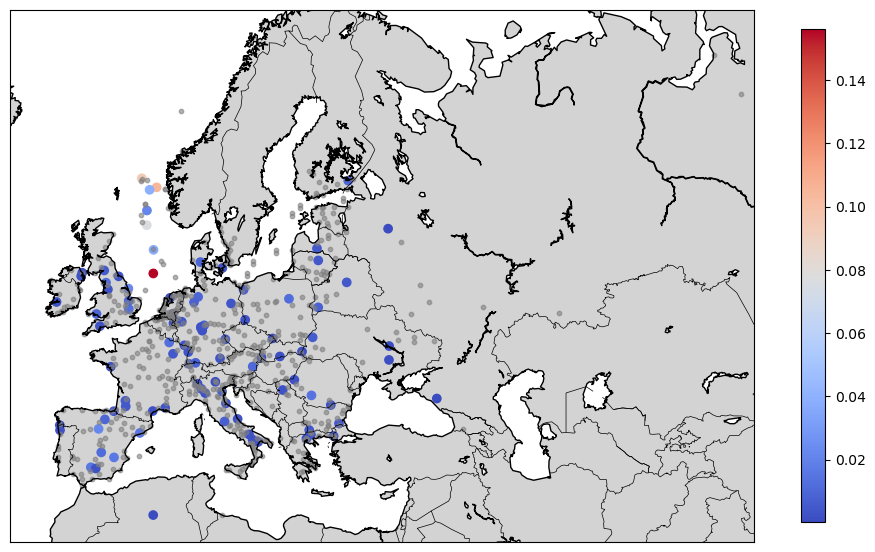

In [6]:
df = node_removals_df.copy()
df = df.iloc[1:]
# Get the latitude and longitude of the nodes
lats = [G_simple_directed.nodes[node]['lat'] for node in G_simple_directed.nodes() if node in df['removed_entity'].values]
lons = [G_simple_directed.nodes[node]['long'] for node in G_simple_directed.nodes() if node in df['removed_entity'].values]

plt.figure(figsize=(12, 16)) 

# Convert latitude and longitude to map projection coordinates
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=70, llcrnrlon=-15, urcrnrlon=80, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Scatter plot with color representing the capacity robustness flow index
x, y = m(lons, lats)
colors = df[metric+'_diff'].values
sc = m.scatter(x, y, c=colors, cmap='coolwarm')

# Add all other nodes present in the graph that are not in the df to the map, as small grey dots
lats = [G_simple_directed.nodes[node]['lat'] for node in G_simple_directed.nodes() if node not in df['removed_entity'].values]
lons = [G_simple_directed.nodes[node]['long'] for node in G_simple_directed.nodes() if node not in df['removed_entity'].values]
x, y = m(lons, lats)
m.scatter(x, y, c='grey', alpha=0.6, s=10)


# Add colorbar
cbar = plt.colorbar(sc, shrink=0.4, aspect=20)

plt.show()

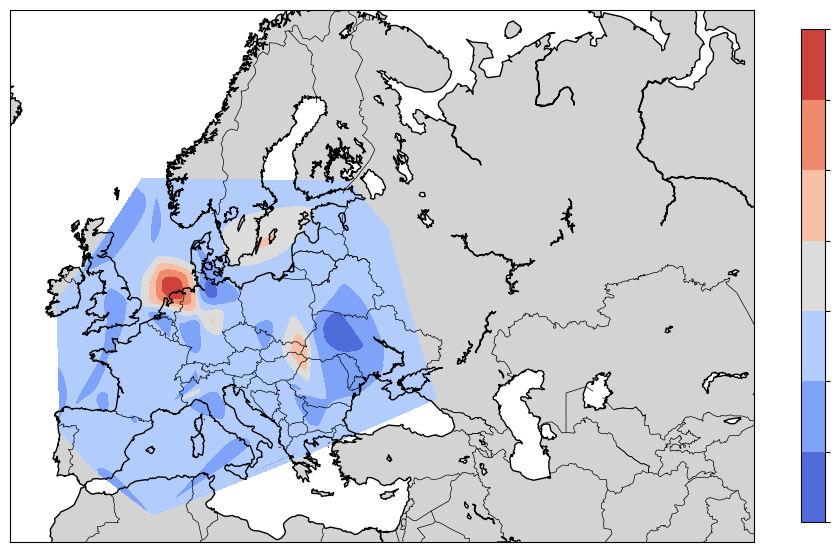

In [7]:
# Get the latitude and longitude of nodes present in the DataFrame
nodes_in_df = df['removed_entity'].values
lats = [G_simple_directed.nodes[node]['lat'] for node in nodes_in_df if node in G_simple_directed.nodes()]
lons = [G_simple_directed.nodes[node]['long'] for node in nodes_in_df if node in G_simple_directed.nodes()]



# Create a grid for interpolation
lon_min, lon_max = min(lons), max(lons)
lat_min, lat_max = min(lats), max(lats)
num_points = 1000
lons_interp = np.linspace(lon_min, lon_max, num_points)
lats_interp = np.linspace(lat_min, lat_max, num_points)
lons_mesh, lats_mesh = np.meshgrid(lons_interp, lats_interp)

# Convert the latitude and longitude of nodes in the DataFrame to numpy array
points = np.array(list(zip(lons, lats)))

# Remove NaN values from the values array
values = df[metric+'_diff'].values
mask = ~np.isnan(values)
values = values[mask]
points = points[mask]

# Interpolate the metric values on the grid
metric_interp = griddata(points, values, (lons_mesh, lats_mesh), method='cubic')

plt.figure(figsize=(12, 16)) 

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=70, llcrnrlon=-15, urcrnrlon=80, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot the interpolated heatmap
x_interp, y_interp = m(lons_mesh, lats_mesh)
sc = m.contourf(x_interp, y_interp, metric_interp, cmap='coolwarm')

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.4, aspect=20)
cbar.ax.yaxis.set_ticklabels([])    

plt.show()
